# 7 - Vertex AI > Training > Custom Jobs - Forecasting with Prophet using Custom Container

In this notebook and open-source solution named [Prophet](https://github.com/facebook/prophet) is utlized for custom forecasting.  Prophet is built on [Stan](https://mc-stan.org/), a probabalistic programming language, and has been implemented in Python and R.  Prophet is built to be robust to outliers and missing data while also being customizable where you can add domain knowledge about the forecasting.  It also offers automated visualizations, including interactive plots using [Plotly](https://plotly.com/graphing-libraries/).  Results are written back to BigQuery using [Pandas gbq](https://github.com/googleapis/python-bigquery-pandas) for further processing in BigQuery.

This notebook demonstrates how to progress from the experimental nature of a notebook based program, like `04e`, to an easy custom application built in a container.  The advantage is that the custom container can them be used as a Vertex AI Training job were it runs as a managed service any time you need to refit the forecast to new or different data.

### Prerequisites:
- 04 - Time Series Forecasting - Data Review in BigQuery
- 04e - Vertex AI > Notebooks - Forecasting with Prophet (Python) - not required but worth reviewing as the code used here was developed in this notebook

### Resources:
- [Vertex AI Custom Container For Training](https://cloud.google.com/vertex-ai/docs/training/containers-overview)

### Conceptual Flow & Workflow
<p align="center">
  <img alt="Conceptual Flow" src="../architectures/slides/afore7_arch.png" width="45%">
&nbsp; &nbsp; &nbsp; &nbsp;
  <img alt="Workflow" src="../architectures/slides/afore7_console.png" width="45%">
</p>

---
## Setup

inputs:

In [1]:
project = !gcloud config get-value project
PROJECT_ID = project[0]
PROJECT_ID

'statmike-mlops-349915'

In [2]:
REGION = 'us-central1'
DATANAME = 'citibikes'
NOTEBOOK = '04f'

BASE_IMAGE = 'gcr.io/deeplearning-platform-release/base-cpu'
TRAIN_COMPUTE = 'n1-standard-8'

packages:

In [3]:
from google.cloud import bigquery
from google.cloud import aiplatform

import matplotlib.pyplot as plt
from datetime import datetime
import json

clients:

In [4]:
aiplatform.init(project=PROJECT_ID, location=REGION)
bq = bigquery.Client()

# helper function for queries
def bq_runner(query):
    return bq.query(query = query)

parameters:

In [5]:
TIMESTAMP = datetime.now().strftime("%Y%m%d%H%M%S")
BUCKET = PROJECT_ID
URI = f"gs://{BUCKET}/{DATANAME}/models/{NOTEBOOK}"
DIR = f"temp/{NOTEBOOK}"

In [138]:
SERVICE_ACCOUNT = !gcloud config list --format='value(core.account)' 
SERVICE_ACCOUNT = SERVICE_ACCOUNT[0]
SERVICE_ACCOUNT

'1026793852137-compute@developer.gserviceaccount.com'

List the service accounts current roles:

In [139]:
!gcloud projects get-iam-policy $PROJECT_ID --filter="bindings.members:$SERVICE_ACCOUNT" --format='table(bindings.role)' --flatten="bindings[].members"

ROLE
roles/bigquery.admin
roles/owner
roles/run.admin
roles/storage.objectAdmin


>Note: If the resulting list is missing [roles/storage.objectAdmin](https://cloud.google.com/storage/docs/access-control/iam-roles) then [revisit the setup notebook](../00%20-%20Setup/00%20-%20Environment%20Setup.ipynb#permissions) and add this permission to the service account with the provided instructions.

environment:

In [7]:
!rm -rf {DIR}
!mkdir -p {DIR}

---
## Training

### Assemble Python File for Training

Create the main python trainer file as `/train.py`:

In [8]:
!mkdir -p {DIR}/model/fit

In [9]:
%%writefile  {DIR}/model/fit/prophet.py
from prophet import Prophet
from google.cloud import bigquery
import pandas as pd
from multiprocessing import Pool, cpu_count
from tqdm import tqdm
import argparse

# import parameters
parser = argparse.ArgumentParser()
parser.add_argument('--PROJECT_ID', dest = 'PROJECT_ID', type = str)
parser.add_argument('--DATANAME', dest = 'DATANAME', type = str)
parser.add_argument('--NOTEBOOK', dest = 'NOTEBOOK', type = str)
parser.add_argument('--horizon', type=int)

parser.add_argument('--yearly', action='store_true')
parser.add_argument('--no-yearly', action='store_false')
parser.set_defaults(yearly=False)

args = parser.parse_args()
PROJECT_ID = args.PROJECT_ID
DATANAME = args.DATANAME
NOTEBOOK = args.NOTEBOOK
print(PROJECT_ID, DATANAME, NOTEBOOK)

# client for BQ
bq = bigquery.Client(project = PROJECT_ID)

# input data - from BQ
query = f"SELECT * FROM `{PROJECT_ID}.{DATANAME}.{DATANAME}_prepped` ORDER by start_station_name, date"
source = bq.query(query = query).to_dataframe()

# preprocess data - as a list of dataframes for each series
seriesNames = source['start_station_name'].unique().tolist()
seriesFrames = []
for s in seriesNames:
    frame = source[(source['start_station_name']==s) & (source['splits']!='TEST')][['date','num_trips']].rename(columns={'date':'ds','num_trips':'y'})
    seriesFrames.append(frame)

# function to run a prophet fit & forecast
def run_prophet(series):
    if args.yearly:
        p = Prophet(weekly_seasonality=True, yearly_seasonality=True)
    else:
        p = Prophet(weekly_seasonality=True)
    p.add_country_holidays(country_name='US')
    p.fit(series)
    f = p.make_future_dataframe(periods = 2* args.horizon)
    f = p.predict(f)
    return f[['ds','yhat','yhat_lower','yhat_upper']]

# run the series in a thread pool for multiprocessing
pool = Pool(cpu_count())
predictions = list(tqdm(pool.imap(run_prophet, seriesFrames), total = len(seriesFrames)))
pool.close()
pool.join()

# postprocess data - add series name back to dataframe and concatenate all into one dataframe
for i, p in enumerate(predictions):
    p['start_station_name'] = seriesNames[i]
output = pd.concat(predictions)

# output data - to BQ
output.to_gbq(f"{PROJECT_ID}.{DATANAME}.{NOTEBOOK}_prophet", f'{PROJECT_ID}', if_exists = 'replace')

# Transform final data in BQ - merge with original input
query = f"""
CREATE OR REPLACE TABLE `{PROJECT_ID}.{DATANAME}.{NOTEBOOK}_prophet` AS
WITH
    SOURCE AS (
        SELECT *
        FROM `{PROJECT_ID}.{DATANAME}.{DATANAME}_prepped`
    ),
    PROPHET AS (
        SELECT start_station_name, DATE(ds) as date, yhat, yhat_lower, yhat_upper
        FROM `{PROJECT_ID}.{DATANAME}.{NOTEBOOK}_prophet`
    )
SELECT *
FROM PROPHET
LEFT OUTER JOIN SOURCE
USING (start_station_name, date)
ORDER by start_station_name, date
"""
Tjob = bq.query(query = query)
Tjob.result()
(Tjob.ended-Tjob.started).total_seconds()

Writing temp/04f/model/fit/prophet.py


### Create Custom Container
- https://cloud.google.com/vertex-ai/docs/training/create-custom-container
- https://cloud.google.com/vertex-ai/docs/training/pre-built-containers
- https://cloud.google.com/vertex-ai/docs/general/deep-learning
    - https://cloud.google.com/deep-learning-containers/docs/choosing-container

#### Choose a Base Image

In [10]:
BASE_IMAGE # Defined above in Setup

'gcr.io/deeplearning-platform-release/base-cpu'

#### Create the Dockerfile
A basic dockerfile thats take the base image and copies the code in and define an entrypoint - what python script to run first in this case.  Add RUN entries to pip install additional packages.

In [11]:
dockerfile = f"""
FROM {BASE_IMAGE}
WORKDIR /
RUN pip install pandas pystan==2.19.1.1 prophet pandas-gbq google-cloud-bigquery pyarrow tqdm
## Copies the trainer code to the docker image
COPY fit /fit
## Sets up the entry point to invoke the trainer
ENTRYPOINT ["python", "-m", "fit.prophet"]
"""
with open(f'{DIR}/model/Dockerfile', 'w') as f:
    f.write(dockerfile)

#### Setup Artifact Registry

The container will need to be stored in Artifact Registry, Container Registry or Docker Hub in order to be used by Vertex AI Training jobs.  This notebook will setup Artifact registry and push a local (to this notebook) built container to it. 

https://cloud.google.com/artifact-registry/docs/docker/store-docker-container-images#gcloud

##### Enable Artifact Registry API:
Check to see if the api is enabled, if not then enable it:

In [12]:
services = !gcloud services list --format="json" --available --filter=name:artifactregistry.googleapis.com
services = json.loads("".join(services))

if (services[0]['config']['name'] == 'artifactregistry.googleapis.com') & (services[0]['state'] == 'ENABLED'):
    print(f"Artifact Registry is Enabled for This Project: {PROJECT_ID}")
else:
    print(f"Enabeling Artifact Registry for this Project: {PROJECT_ID}")
    !gcloud services enable artifactregistry.googleapis.com

Artifact Registry is Enabled for This Project: statmike-mlops-349915


##### Create A Repository
Check to see if the registry is already created, if not then create it

In [13]:
check_for_repo = !gcloud artifacts repositories describe {PROJECT_ID} --location={REGION}

if check_for_repo[0].startswith('ERROR'):
    print(f'Creating a repository named {PROJECT_ID}')
    !gcloud  artifacts repositories create {PROJECT_ID} --repository-format=docker --location={REGION} --description="Vertex AI Training Custom Containers"
else:
    print(f'There is already a repository named {PROJECT_ID}')

There is already a repository named statmike-mlops-349915


##### Configure Local Docker to Use GCLOUD CLI

In [14]:
!gcloud auth configure-docker {REGION}-docker.pkg.dev --quiet


{
  "credHelpers": {
    "gcr.io": "gcloud",
    "us.gcr.io": "gcloud",
    "eu.gcr.io": "gcloud",
    "asia.gcr.io": "gcloud",
    "staging-k8s.gcr.io": "gcloud",
    "marketplace.gcr.io": "gcloud",
    "us-central1-docker.pkg.dev": "gcloud"
  }
}
Adding credentials for: us-central1-docker.pkg.dev
gcloud credential helpers already registered correctly.


#### Build The Custom Container (local to notebook)

In [15]:
IMAGE_URI=f"{REGION}-docker.pkg.dev/{PROJECT_ID}/{PROJECT_ID}/{NOTEBOOK}:latest"
IMAGE_URI

'us-central1-docker.pkg.dev/statmike-mlops-349915/statmike-mlops-349915/04f:latest'

In [16]:
!docker build {DIR}/model/. -t $IMAGE_URI

Sending build context to Docker daemon  6.144kB
Step 1/5 : FROM gcr.io/deeplearning-platform-release/base-cpu
latest: Pulling from deeplearning-platform-release/base-cpu

e07ed847: Already exists 
16f81350: Already exists 
b700ef54: Already exists 
3557648b: Already exists 
b700ef54: Already exists 
6bf6eafe: Already exists 
bba293d2: Already exists 
28c2780c: Already exists 
0ff26dd4: Already exists 
59a1007a: Already exists 
4ccc646d: Already exists 
e8e43491: Already exists 
fc1617dd: Already exists 
6205e6a8: Already exists 
7f764283: Already exists 
c87c58c1: Already exists 
898486c4: Pulling fs layer 
Digest: sha256:fd1a6b82332194835f0dd686b8b9e8f8e372919e0e83e6663160b823dd65e194[2A
Status: Downloaded newer image for gcr.io/deeplearning-platform-release/base-cpu:latest
 ---> 234ba2bc2b77
Step 2/5 : WORKDIR /
 ---> Running in 696c34ae15dd
Removing intermediate container 696c34ae15dd
 ---> bf9f9e22b0b2
Step 3/5 : RUN pip install pandas pystan==2.19.1.1 prophet pandas-gbq google-clo

#### Test The Custom Container (local to notebook)

In [17]:
!docker run {IMAGE_URI} --PROJECT_ID {PROJECT_ID} --DATANAME {DATANAME} --NOTEBOOK {NOTEBOOK} --horizon {14} --no-yearly

Importing plotly failed. Interactive plots will not work.
statmike-mlops-349915 citibikes 04f
  0%|          | 0/12 [00:00<?, ?it/s]13:34:28 - cmdstanpy - INFO - Chain [1] start processing
13:34:28 - cmdstanpy - INFO - Chain [1] start processing
13:34:28 - cmdstanpy - INFO - Chain [1] start processing
13:34:28 - cmdstanpy - INFO - Chain [1] start processing
13:34:28 - cmdstanpy - INFO - Chain [1] done processing
13:34:28 - cmdstanpy - INFO - Chain [1] done processing
13:34:28 - cmdstanpy - INFO - Chain [1] done processing
13:34:29 - cmdstanpy - INFO - Chain [1] done processing
  8%|▊         | 1/12 [00:04<00:45,  4.15s/it]13:34:32 - cmdstanpy - INFO - Chain [1] start processing
13:34:33 - cmdstanpy - INFO - Chain [1] done processing
13:34:33 - cmdstanpy - INFO - Chain [1] start processing
13:34:33 - cmdstanpy - INFO - Chain [1] done processing
13:34:33 - cmdstanpy - INFO - Chain [1] start processing
13:34:34 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 2/12 [00:07<00

#### Push The Custom Container To Artifact Registry

In [18]:
!docker push $IMAGE_URI

The push refers to repository [us-central1-docker.pkg.dev/statmike-mlops-349915/statmike-mlops-349915/04f]

ff9e70df: Preparing 
85bb0c37: Preparing 
d552a12c: Preparing 
d71ff37a: Preparing 
59dfa907: Preparing 
668df2d8: Preparing 
767a76ae: Preparing 
559b3e11: Preparing 
c5f28369: Preparing 
eeca4cbf: Preparing 
c2b66f65: Preparing 
0bba959a: Preparing 
677fbd36: Preparing 
713472f0: Preparing 
33654a88: Preparing 
bf18a086: Preparing 
5cfc6aa2: Preparing 
bf18a086: Preparing 
4b178955: Preparing 
71ff37a: Pushed   1.848GB/1.771GBlatest: digest: sha256:00cbeefed465a63d5c0b4cacad477b0a52f75258a023bc777ceeb54c3ee64b2d size: 4707


### Setup Training Job

In [19]:
CMDARGS = [
    "--PROJECT_ID=" + PROJECT_ID,
    "--DATANAME=" + DATANAME,
    "--NOTEBOOK=" + NOTEBOOK,
    "--horizon=" + '14',
    "--no-yearly"
]

MACHINE_SPEC = {
    "machine_type": TRAIN_COMPUTE,
    "accelerator_count": 0
}

WORKER_POOL_SPEC = [
    {
        "replica_count": 1,
        "machine_spec": MACHINE_SPEC,
        "container_spec": {
            "image_uri": IMAGE_URI,
            "command": [],
            "args": CMDARGS
        }
    }
]

In [20]:
customJob = aiplatform.CustomJob(
    display_name = f'{NOTEBOOK}_{DATANAME}',
    worker_pool_specs = WORKER_POOL_SPEC,
    base_output_dir = f"{URI}/{TIMESTAMP}",
    staging_bucket = f"{URI}/{TIMESTAMP}",
    labels = {'notebook':f'{NOTEBOOK}', 'yearly':'false'}
)

### Run Training Job

In [21]:
customJob.run(
    service_account = SERVICE_ACCOUNT,
    sync = False
)

Creating CustomJob
CustomJob created. Resource name: projects/1026793852137/locations/us-central1/customJobs/5084600538062913536
To use this CustomJob in another session:
custom_job = aiplatform.CustomJob.get('projects/1026793852137/locations/us-central1/customJobs/5084600538062913536')
View Custom Job:
https://console.cloud.google.com/ai/platform/locations/us-central1/training/5084600538062913536?project=1026793852137


In [23]:
customJob.display_name

'04f_citibikes'

## Results

### Retrieve Test Data

In [24]:
prophet = bq_runner(
    query = f"""
        SELECT
            date, 
            num_trips, 
            splits, 
            start_station_name, 
            yhat as predicted_num_trips
        FROM `{PROJECT_ID}.{DATANAME}.{NOTEBOOK}_prophet`
        WHERE splits = 'TEST'
    """
).to_dataframe()
prophet

,date,num_trips,splits,start_station_name,predicted_num_trips
0,2016-09-17,269,TEST,Central Park North & Adam Clayton Powell Blvd,242.627804
1,2016-09-18,272,TEST,Central Park North & Adam Clayton Powell Blvd,296.626871
2,2016-09-19,39,TEST,Central Park North & Adam Clayton Powell Blvd,162.764815
3,2016-09-20,120,TEST,Central Park North & Adam Clayton Powell Blvd,145.628845
4,2016-09-21,164,TEST,Central Park North & Adam Clayton Powell Blvd,146.128736
...,...,...,...,...,...
154,2016-09-26,102,TEST,W 82 St & Central Park West,74.407411
155,2016-09-27,105,TEST,W 82 St & Central Park West,73.936957
156,2016-09-28,72,TEST,W 82 St & Central Park West,77.706083
157,2016-09-29,143,TEST,W 82 St & Central Park West,74.782304


### Review Custom Metrics with SQL

Some common metrics for evaluating forecasting effectiveness are 
- MAPE, or Mean Absolute Percentage Error
    - $\textrm{MAPE} = \frac{1}{n}\sum{\frac{\mid(actual - forecast)\mid}{actual}}$
- MAE, or Mean Absolute Error
     - $\textrm{MAE} = \frac{1}{n}\sum{\mid(actual - forecast)\mid}$
- MAE divided by average demand so it yields a % like MAPE
    - $\textrm{pMAE} = \frac{\sum{\mid(actual - forecast)\mid}}{\sum{actual}}$
- MSE, or Mean Squared Error
    - $\textrm{MSE} = \frac{1}{n}\sum{(actual-forecast)^2}$
- RMSE, or Root Mean Squared Error
    - $\textrm{RMSE} = \sqrt{\frac{1}{n}\sum{(actual-forecast)^2}}$
- RMSE divided by average demand so it yeilds a % like MAPE
    - $\textrm{pRMSE} = \frac{\sqrt{\frac{1}{n}\sum{(actual-forecast)^2}}}{\frac{1}{n}\sum{actual}}$

It can be helpful to explicity caculate these to make comparison between datasets and models fair.  This section demonstration these calculation with SQL.

In [25]:
customMetrics = bq_runner(
    query = f"""
        WITH
            FORECASTS AS (
                SELECT
                    date, 
                    num_trips, 
                    splits, 
                    start_station_name, 
                    yhat as predicted_num_trips
                FROM `{PROJECT_ID}.{DATANAME}.{NOTEBOOK}_prophet`
                WHERE splits = 'TEST'
            ),
            DIFFS AS (
                SELECT 
                    start_station_name, date, 'forecast' as time_series_type,
                    predicted_num_trips as forecast_value,
                    num_trips as actual_value,
                    (num_trips - predicted_num_trips) as diff
                FROM FORECASTS    
            )
        SELECT start_station_name, time_series_type, 
            AVG(ABS(diff)/actual_value) as MAPE,
            AVG(ABS(diff)) as MAE,
            SUM(ABS(diff))/SUM(actual_value) as pMAE,
            AVG(POW(diff, 2)) as MSE,
            SQRT(AVG(POW(diff, 2))) as RMSE,
            SQRT(AVG(POW(diff, 2)))/AVG(actual_value) as pRMSE,
            COUNT(diff) as n
        FROM DIFFS
        GROUP BY start_station_name, time_series_type
        ORDER BY start_station_name, time_series_type    
    """
).to_dataframe()
customMetrics

,start_station_name,time_series_type,MAPE,MAE,pMAE,MSE,RMSE,pRMSE,n
0,Central Park North & Adam Clayton Powell Blvd,forecast,0.783951,48.905733,0.315085,4056.136186,63.687802,0.410322,14
1,Central Park S & 6 Ave,forecast,0.475182,93.037545,0.285079,13164.384312,114.736151,0.351566,14
2,Central Park W & W 96 St,forecast,0.463691,25.280066,0.252620,893.017541,29.883399,0.298621,14
3,Central Park West & W 100 St,forecast,0.718591,14.844421,0.374454,285.879349,16.907967,0.426507,14
4,Central Park West & W 102 St,forecast,0.466372,11.348224,0.224083,231.763229,15.223772,0.300610,14
5,Central Park West & W 68 St,forecast,0.551993,49.844157,0.329004,3673.841275,60.612221,0.400081,14
6,Central Park West & W 72 St,forecast,0.667743,48.044807,0.271558,4562.843432,67.548823,0.381798,13
7,Central Park West & W 76 St,forecast,0.421498,29.932974,0.273360,1382.066427,37.176154,0.339508,14
8,Central Park West & W 85 St,forecast,1.049834,48.384986,0.384881,3656.053827,60.465311,0.480974,7
9,Grand Army Plaza & Central Park S,forecast,0.421359,44.519473,0.204723,3890.800322,62.376280,0.286838,13


Overall Metrics:

In [26]:
customMetricsOverall = bq_runner(
    query = f"""
        WITH
            FORECASTS AS (
                SELECT
                    date, 
                    num_trips, 
                    splits, 
                    start_station_name, 
                    yhat as predicted_num_trips
                FROM `{PROJECT_ID}.{DATANAME}.{NOTEBOOK}_prophet`
                WHERE splits = 'TEST'
            ),
            DIFFS AS (
                SELECT 
                    start_station_name, date, 'forecast' as time_series_type,
                    predicted_num_trips as forecast_value,
                    num_trips as actual_value,
                    (num_trips - predicted_num_trips) as diff
                FROM FORECASTS    
            )
        SELECT time_series_type, 
            AVG(ABS(diff)/actual_value) as MAPE,
            AVG(ABS(diff)) as MAE,
            SUM(ABS(diff))/SUM(actual_value) as pMAE,
            AVG(POW(diff, 2)) as MSE,
            SQRT(AVG(POW(diff, 2))) as RMSE,
            SQRT(AVG(POW(diff, 2)))/AVG(actual_value) as pRMSE,
            COUNT(diff) as n
        FROM DIFFS
        GROUP BY time_series_type
        ORDER BY time_series_type     
    """
).to_dataframe()
customMetricsOverall

,time_series_type,MAPE,MAE,pMAE,MSE,RMSE,pRMSE,n
0,forecast,0.534509,37.924562,0.283165,3094.318273,55.626597,0.415338,159


### Retrieve the Forecasting Data

In [27]:
prophet = bq_runner(
    query = f"""
        SELECT *
        FROM `{PROJECT_ID}.{DATANAME}.{NOTEBOOK}_prophet`
        ORDER by start_station_name, date
    """
).to_dataframe()

Retrieve key dates for visualization:

In [28]:
keyDates = bq_runner(
    query = f"""
        WITH
            SPLIT AS (
                SELECT splits, min(date) as mindate, max(date) as maxdate
                FROM `{PROJECT_ID}.{DATANAME}.{DATANAME}_prepped`
                GROUP BY splits
            ),
            TRAIN AS (
                SELECT mindate as start_date
                FROM SPLIT
                WHERE splits ='TRAIN'
            ),
            VAL AS (
                SELECT mindate as val_start
                FROM SPLIT
                WHERE splits = 'VALIDATE'
            ),
            TEST AS (
                SELECT mindate as test_start, maxdate as end_date, DATE_DIFF(maxdate, mindate, DAY)+1 as forecast_horizon
                FROM SPLIT
                WHERE splits = 'TEST'
            )
        SELECT * EXCEPT(pos) FROM
        (SELECT *, ROW_NUMBER() OVER() pos FROM TRAIN)
        JOIN (SELECT *, ROW_NUMBER() OVER() pos FROM VAL)
        USING (pos)
        JOIN (SELECT *, ROW_NUMBER() OVER() pos FROM TEST)
        USING (pos)
    """
).to_dataframe()
keyDates

,start_date,val_start,test_start,end_date,forecast_horizon
0,2013-07-01,2016-09-03,2016-09-17,2016-09-30,14


### Visualize The Time Series with Forecast

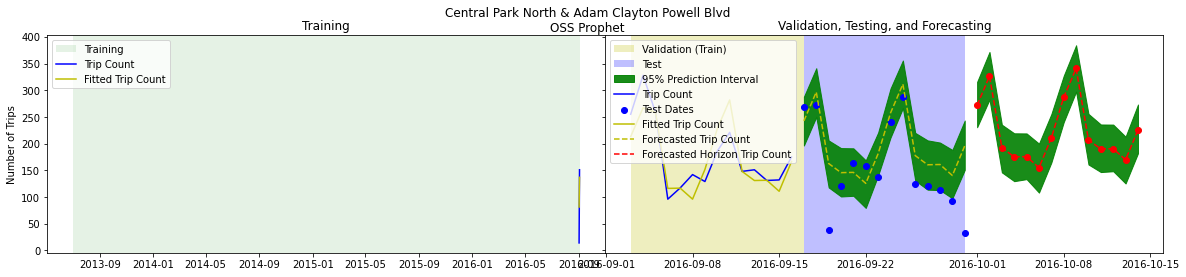

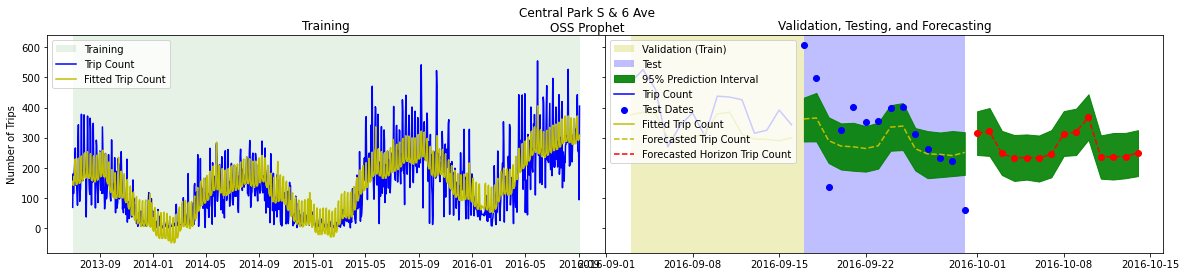

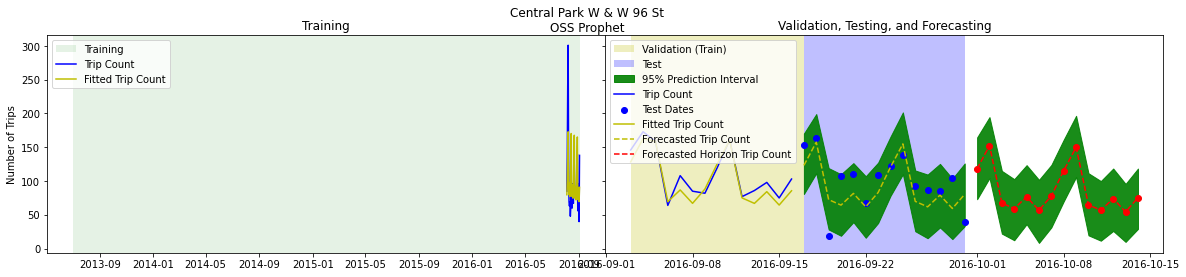

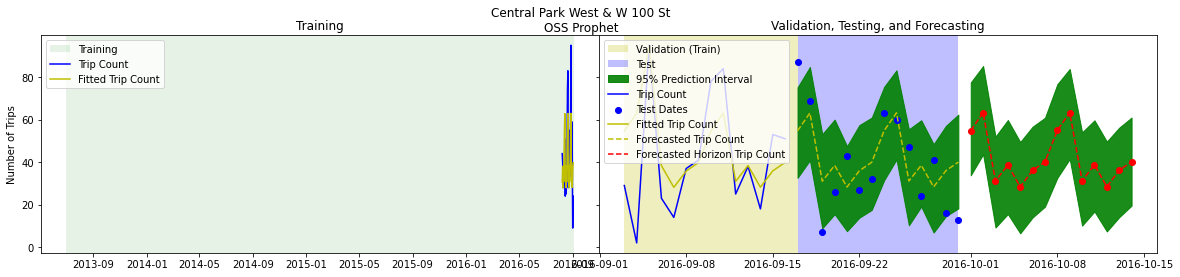

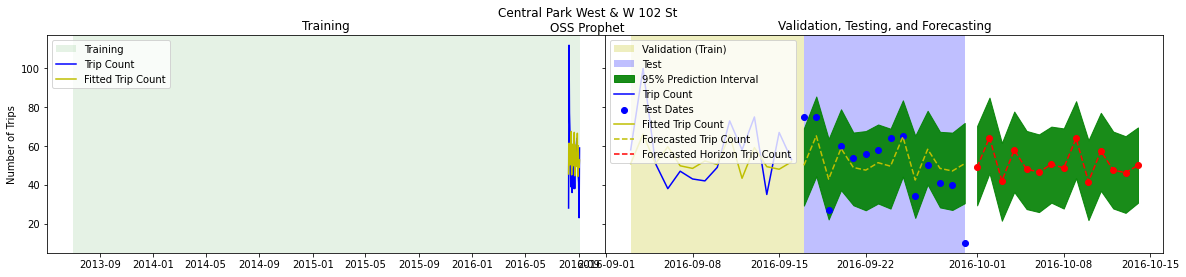

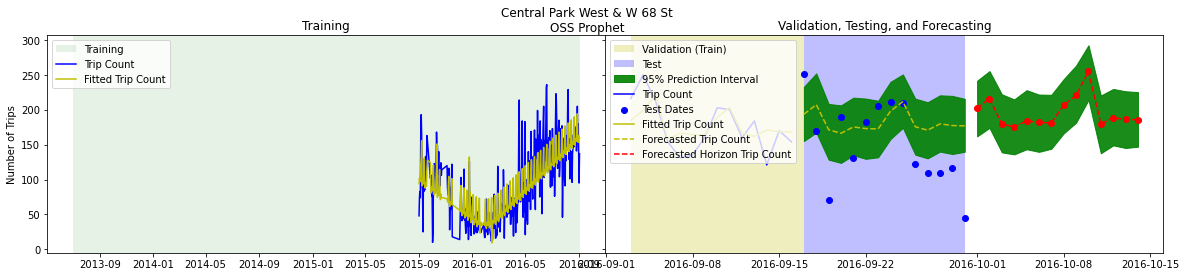

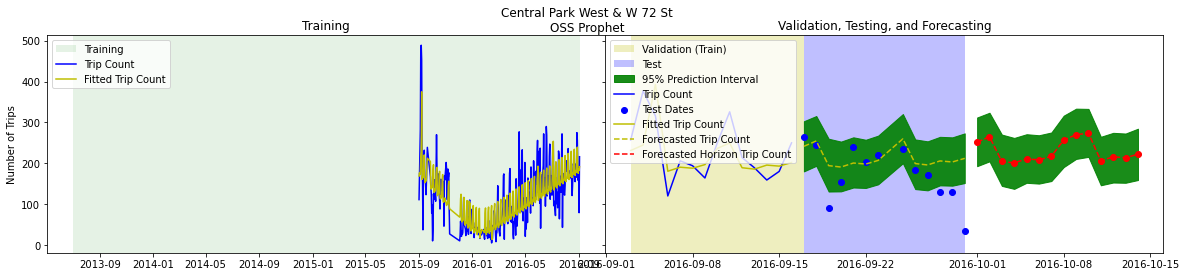

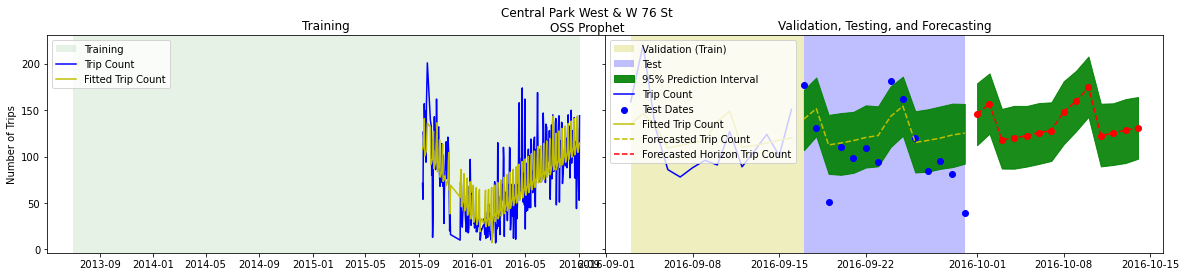

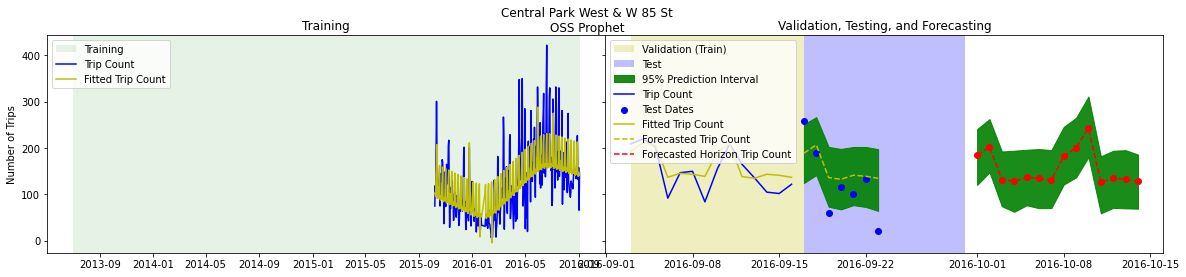

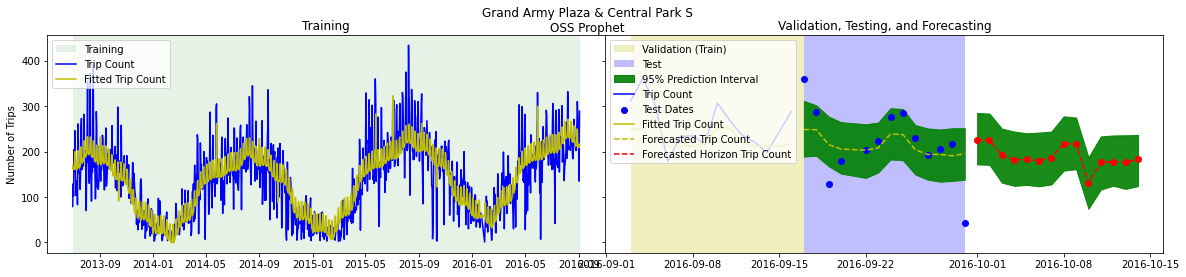

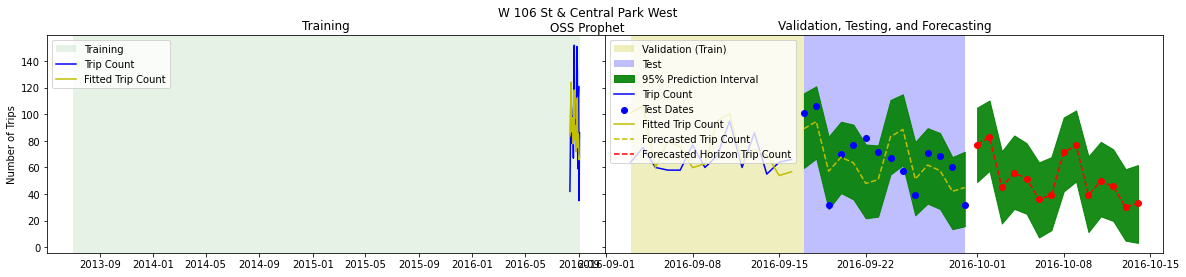

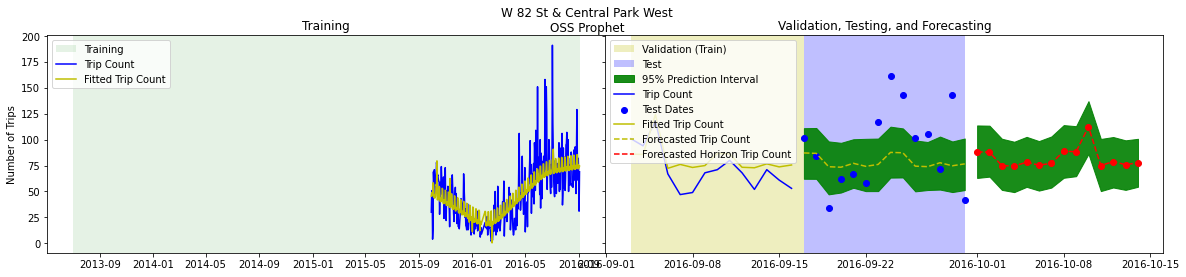

In [30]:
stations = prophet['start_station_name'].unique().tolist()
for s, st in enumerate(stations):
    # setup plot area
    fig, axes = plt.subplots(1, 2, figsize=(20, 4), sharex=False, sharey=True)
    fig.subplots_adjust(wspace=0)
    
    # data
    traindf = prophet[(prophet['start_station_name'] == st) & (prophet['splits'] == 'TRAIN')]
    valdf = prophet[(prophet['start_station_name'] == st) & (prophet['splits'] == 'VALIDATE')]
    testdf = prophet[(prophet['start_station_name'] == st) & (prophet['splits'] == 'TEST')]
    horizondf = prophet[(prophet['start_station_name'] == st) & (prophet['splits'].isna()) & (prophet['date'] > keyDates['end_date'][0])]
    #fit_testdf = autoML[(autoML['start_station_name'] == st) & (autoML['splits'] == 'TEST')]
    
    # regions
    axes[0].axvspan(keyDates['start_date'][0], keyDates['val_start'][0], facecolor='g', alpha = 0.1, label = 'Training')
    axes[1].axvspan(keyDates['val_start'][0], keyDates['test_start'][0], facecolor='y', alpha = 0.25, label = 'Validation (Train)')
    axes[1].axvspan(keyDates['test_start'][0], keyDates['end_date'][0], facecolor='b', alpha = 0.25, label = 'Test')
    axes[1].fill_between(testdf['date'], testdf['yhat_lower'], testdf['yhat_upper'], color = 'g', alpha = 0.9, label = '95% Prediction Interval')
    axes[1].fill_between(horizondf['date'], horizondf['yhat_lower'], horizondf['yhat_upper'], color = 'g', alpha = 0.9)
    
    
    # lines and dots
    axes[0].plot(traindf['date'], traindf['num_trips'], color = 'b', label = 'Trip Count')
    axes[1].plot(valdf['date'], valdf['num_trips'], color = 'b', label = 'Trip Count')
    axes[1].scatter(testdf['date'], testdf['num_trips'], color = 'b', label = 'Test Dates')
    axes[1].scatter(horizondf['date'], horizondf['yhat'], color = 'r')
    
    axes[0].plot(traindf['date'], traindf['yhat'], color = 'y', label = 'Fitted Trip Count', linestyle='solid')
    axes[1].plot(valdf['date'], valdf['yhat'], color = 'y', label = 'Fitted Trip Count', linestyle='solid')
    axes[1].plot(testdf['date'], testdf['yhat'], color = 'y', label = 'Forecasted Trip Count', linestyle='dashed')
    axes[1].plot(horizondf['date'], horizondf['yhat'], color = 'r', label = 'Forecasted Horizon Trip Count', linestyle='dashed')
    #axes[1].scatter(testdf['date'], testdf['yhat'], color = 'y')
    
    # labels
    axes[0].set_ylabel('Number of Trips')
    axes[0].set_title('Training')
    axes[1].set_title('Validation, Testing, and Forecasting')
    axes[1].legend(loc = 'upper left')
    axes[0].legend(loc = 'upper left')
    plt.suptitle(st + f"\nOSS Prophet")

    # display result
    plt.show()

---
## Remove Resources
see notebook "99 - Cleanup"